## блиотеки

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import os
from os import listdir
from os.path import isfile, join

#для случайного леса
from sklearn.ensemble import RandomForestRegressor

#для оценки
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

import copy

import seaborn as sns

#для визуализации времени работы
from tqdm import tqdm, trange

import requests

import json

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Веса

In [ ]:
import json

path = r"/content/drive/MyDrive/НИР/НИР 3 сем /данные/grid_coeffs.json"

with open(path, "r", encoding="utf-8") as f:
    text = f.read()

grid_coeffs= json.loads(text)
print(grid_coeffs.keys())

dict_keys(['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc'])


In [ ]:
pd.DataFrame(grid_coeffs).reindex(['dev', 'soc', 'bas'])

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,"{'avgsaldiff': 0.3720093263004776, 'visiblecom...",{'library': 1.0},"{'library': 0.1574469656845473, 'musartschool'...","{'museums': 0.5563997704977163, 'naturesecure'..."
soc,"{'shoparea': 0.09922722887534528, 'retailturno...","{'shoparea': 0.04115083265801652, 'retailturno...","{'shoparea': 0.09139153656187642, 'retailturno...","{'shoparea': 0.041055772217314886, 'retailturn...","{'cultureorg': 0.697934363352477, 'parks': 0.2..."
bas,"{'livarea': 0.3226616882753846, 'servicesnum':...","{'livarea': 0.41221159417345926, 'servicesnum'...","{'livarea': 0.3226616882753846, 'servicesnum':...","{'livarea': 0.13030181280000322, 'servicesnum'...",{'badhousesdwellers': -1.0}


In [ ]:
grid_coeffs

{'comm': {'soc': {'shoparea': 0.09922722887534528,
   'retailturnover': 0.17346823500293415,
   'sportsvenue': 0.1286099407249109,
   'roadslen': 0.13831769586227158,
   'invest': 0.08838391427597161,
   'hospitals': 0.20531235797109135,
   'cliniccap': 0.08743871710515405,
   'docsnum': 0.07924191018232106},
  'bas': {'livarea': 0.3226616882753846,
   'servicesnum': 0.22610663082474283,
   'budincome': 0.23564785200407534,
   'pollutionvol': -0.20786378774470077,
   'litstreetperc': 0.18999875100962468,
   'munipoliceworkers': 0.08510758510803965,
   'pollutcapturedperc': 0.14834128052283374}},
 'soc_workers': {'dev': {'avgsaldiff': 0.3720093263004776,
   'visiblecompanies': 0.6279906736995224},
  'soc': {'shoparea': 0.04115083265801652,
   'retailturnover': 0.07193955117959437,
   'sportsvenue': 0.0533362284618151,
   'roadslen': 0.05736216178344782,
   'invest': 0.036653967940594966,
   'hospitals': 0.08514572644273861,
   'cliniccap': 0.03626198228256548,
   'docsnum': 0.0328626589

In [ ]:
import numpy as np
import pandas as pd
import copy

def loc_counts(loc_data, grid_coeffs):
    n_coeffs = copy.deepcopy(grid_coeffs)
    for col in grid_coeffs.keys():
        for row in grid_coeffs[col].keys():
            cell_sum = 0
            for indicator in grid_coeffs[col][row].keys():
                value = loc_data.get(indicator, 0)
                if pd.isna(value):
                    value = 0
                cell_sum += value * grid_coeffs[col][row][indicator]
            n_coeffs[col][row] = cell_sum
    return pd.DataFrame(n_coeffs).reindex(['dev', 'soc', 'bas'])

def tab_to_ser(df, loc = None):
    sr = pd.Series(df.values.flatten(), index = ['comm_dev', 'soc_workers_dev', 'soc_old_dev', 'soc_parents_dev', 'loc_dev',
                                                 'comm_soc', 'soc_workers_soc', 'soc_old_soc', 'soc_parents_soc', 'loc_soc',
                                                 'comm_base', 'soc_workers_base', 'soc_old_base', 'soc_parents_base', 'loc_base'])
    if loc:
        sr.name = loc
    return sr

## Загругка датасета

In [ ]:
result= pd.read_csv('/content/drive/MyDrive/НИР/НИР 3 сем /данные/data_for_pred.csv')
result.head()

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc,risk
0,1601000.0,2011.0,Алейский муниципальный район,21.010055,0.000480,0.861,NaN,0.013011,NaN,0.025603,...,0.012412,16678.0,0.004617,0.299292,0.001979,-0.084687,NaN,NaN,0.199522,NaN
1,1601000.0,2012.0,Алейский муниципальный район,21.010055,0.000379,0.861,NaN,0.011616,NaN,0.029419,...,0.021837,15840.0,0.004861,0.317058,0.001894,-0.050539,NaN,NaN,0.199522,NaN
2,1601000.0,2013.0,Алейский муниципальный район,21.010055,0.000390,0.861,NaN,0.011968,NaN,0.031677,...,0.024093,15374.0,0.005008,0.335040,0.001431,-0.025876,NaN,NaN,0.199522,NaN
3,1601000.0,2014.0,Алейский муниципальный район,21.010055,0.000390,0.861,NaN,0.011968,NaN,0.034001,...,0.024502,15117.0,0.005094,0.342264,0.001323,-0.032250,NaN,NaN,0.199522,NaN
4,1601000.0,2015.0,Алейский муниципальный район,27.959829,0.000390,0.861,NaN,0.011968,NaN,0.032752,...,0.024758,14961.0,0.005147,0.315166,0.001203,-0.022050,NaN,NaN,0.173596,NaN


In [ ]:
import numpy as np
import pandas as pd

recom = pd.read_csv('/content/Кандалакшский муниципальный район.csv')
recom

p_result = result[(result['oktmo'] == 47608000) & (result['year'] == 2021)].copy()
p_result
# если recom читаешь из CSV
# recom = pd.read_csv("/mnt/data/Пыть-Ях.csv")

mask = (result['name'] == 'Кандалакшский муниципальный район') & (result['year'] == 2021)
p_result = result.loc[mask].copy()

for _, row in recom.iterrows():
    feature = row['feature']  # <-- было row['index'], из-за этого KeyError

    if feature not in p_result.columns:
        continue

    pct = row['pct_change']
    spv = row.get('special_new_value', np.nan)

    # 1) pct_change НЕ NaN -> старый подход (умножаем)
    if pd.notna(pct):
        percentage = pct / 100.0
        p_result[feature] = pd.to_numeric(p_result[feature], errors='coerce') * (1 + percentage)

    # 2) pct_change NaN -> подставляем special_new_value
    else:
        if pd.notna(spv):
            p_result[feature] = float(spv)

# записываем обратно в result (только затронутые колонки)
touched = [c for c in recom['feature'].tolist() if c in result.columns]
result.loc[mask, touched] = p_result[touched].values

## Выбираем год для исследования

In [ ]:
result_norm = result[(result.year ==2021)]

In [ ]:

# Исключаем столбцы 'year' и 'oktmo' из нормализации и окрашивания
columns_to_normalize = [col for col in result_norm.columns if col not in ['oktmo', 'year','ydel_saldo','name' ]]

result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())

/tmp/ipython-input-3223910686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_norm[columns_to_normalize] = (result_norm[columns_to_normalize] - result_norm[columns_to_normalize].min()) / (result_norm[columns_to_normalize].max() - result_norm[columns_to_normalize].min())


In [ ]:
result_norm[(result_norm['oktmo'] == 47608000)]

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc,risk
8807,47608000.0,2021.0,Кандалакшский муниципальный район,0.008418,0.249826,NaN,1.0,0.073232,0.030403,0.59263,...,0.030611,0.023662,0.129268,0.160641,0.173814,-0.020645,0.495806,0.029871,0.636978,0.77033


In [ ]:
# Функция для векторного подсчёта (использует loc_counts)
def calculate_loc_counts(row):
    loc_data = loc_counts(row, grid_coeffs)  # Рассчитываем метрики для строки
    loc_series = tab_to_ser(loc_data, row.name)  # Преобразуем таблицу в серию
    loc_series['oktmo'] = row['oktmo']  # Добавляем oktmo
    loc_series['year'] = row['year']    # Добавляем year
    loc_series['ydel_saldo'] = row['ydel_saldo']
    return loc_series

# Применяем функцию ко всем строкам таблицы result
full_df = result_norm.apply(calculate_loc_counts, axis=1)
full_df['year'] = pd.to_numeric(full_df['year'], errors='coerce').astype('Int64')
full_df['oktmo'] = pd.to_numeric(full_df['oktmo'], errors='coerce').astype('Int64')

## Выбираем район РФ - надымский

In [ ]:

rez = result_norm
rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')
rez=rez[(rez.oktmo >= 47000000) & (rez.oktmo < 48000000)]
rez.name.unique().tolist()

/tmp/ipython-input-879646334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['year'] = pd.to_numeric(rez['year'], errors='coerce').astype('Int64')
/tmp/ipython-input-879646334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rez['oktmo'] = pd.to_numeric(rez['oktmo'], errors='coerce').astype('Int64')


['Печенгский муниципальный округ',
 'город Апатиты',
 'город Кировск',
 'город Мончегорск',
 'город Оленегорск',
 'город Полярные Зори',
 'Кольский муниципальный район',
 'Кандалакшский муниципальный район',
 'Ловозерский муниципальный район',
 'город-герой Мурманск']

In [ ]:
rez.head()

,oktmo,year,name,factoriescap,docsnum,consnewapt,circuses,cliniccap,cinemas,beforeschool,...,roadslen,popsize,sportsvenue,shoparea,schoolnum,ydel_saldo,avgsaldiff,badhousesdwellers,litstreetperc,risk
8734,47515000,2021,Печенгский муниципальный округ,0.022486,NaN,NaN,NaN,NaN,NaN,0.573702,...,0.016393,0.020799,0.263421,0.073668,NaN,-0.028735,0.544289,NaN,0.873153,NaN
8745,47519000,2021,город Апатиты,0.002964,0.232094,NaN,NaN,0.100432,0.013689,0.498215,...,0.005340,0.031777,0.231163,0.168878,0.071416,-0.012846,0.258422,NaN,0.946185,NaN
8756,47522000,2021,город Кировск,0.031565,0.289052,NaN,NaN,0.161522,NaN,0.722294,...,0.011180,0.015851,0.179991,0.103193,0.099496,-0.002845,0.258422,NaN,1.000000,NaN
8767,47524000,2021,город Мончегорск,0.229315,0.220181,NaN,NaN,0.109846,0.017014,0.598903,...,0.014405,0.025943,0.148539,0.139020,0.105164,0.005527,0.258422,0.01601,0.744019,NaN
8778,47526000,2021,город Оленегорск,0.023424,0.146322,NaN,NaN,0.048563,0.027228,0.533648,...,0.012674,0.016754,0.280467,0.100223,0.115018,0.012190,0.258422,NaN,0.952806,0.257143


In [ ]:
lo_tab = full_df[(full_df.oktmo >= 47000000) & (full_df.oktmo < 48000000)& (full_df.year ==2021)]
lo_tab

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
8734,NaN,0.229855,0.000000,0.124417,0.022918,0.085428,0.068549,0.078682,0.068391,0.000000,0.289599,0.362836,0.289599,0.116784,0.000000,47515000,2021,-0.028735
8745,NaN,0.137549,0.042943,0.151670,0.024054,0.107150,0.075001,0.098933,0.074828,0.004614,0.415736,0.524888,0.415736,0.167332,0.000000,47519000,2021,-0.012846
8756,NaN,0.195834,0.014552,0.219313,0.129572,0.118169,0.101887,0.109311,0.101652,0.033047,0.446530,0.553576,0.446530,0.196890,0.000000,47522000,2021,-0.002845
8767,NaN,0.158873,0.009139,0.187725,0.126408,0.086845,0.092378,0.080286,0.092165,0.005939,0.444689,0.557944,0.444689,0.176880,-0.016010,47524000,2021,0.005527
8778,NaN,0.118249,0.028142,0.187528,0.042871,0.081364,0.060722,0.075404,0.060582,0.009812,0.416078,0.522527,0.416078,0.165562,0.000000,47526000,2021,0.012190
8789,NaN,0.121173,0.024770,0.221133,0.110359,0.090478,0.080179,0.084138,0.079993,0.037669,0.338225,0.414705,0.338225,0.137328,0.000000,47528000,2021,0.009372
8798,NaN,0.326775,0.071423,0.248702,0.053382,0.140377,0.113318,0.129624,0.113057,0.094923,0.336784,0.413813,0.336784,0.204154,-0.067002,47605000,2021,-0.006781
8807,NaN,0.212349,0.037565,0.222253,0.087086,0.127290,0.086602,0.118155,0.088250,0.104742,0.363044,0.455114,0.363044,0.150461,-0.029871,47608000,2021,-0.020645
8816,NaN,0.226133,0.038497,0.240496,0.137702,0.105614,0.064315,0.098538,0.064166,0.089465,0.349996,0.439137,0.349996,0.144133,-0.006022,47610000,2021,-0.003592
8838,NaN,0.254652,0.007045,0.133096,0.033498,0.131899,0.109682,0.121529,0.109512,0.017964,0.323855,0.401702,0.323855,0.128410,-0.062754,47701000,2021,-0.007174


In [ ]:
# Исключаем столбцы 'year' и 'oktmo' из нормализации и окрашивания
columns_to_normalize = [col for col in lo_tab.columns if col not in ['oktmo', 'year','ydel_saldo' ]]

# Нормировка всех столбцов, кроме 'oktmo' и 'year'
nlo_tab = lo_tab.copy()
nlo_tab[columns_to_normalize] = nlo_tab[columns_to_normalize].apply(lambda s: (s - s.min()) / (s.max() - s.min()), axis=0)

# Применяем стиль окрашивания только к нормированным столбцам (исключаем 'oktmo' и 'year')
def color_cols_custom(s):
    # Проверяем, чтобы окрашивание не применялось к столбцам 'oktmo' и 'year'
    if s.name in ['oktmo', 'year','ydel_saldo']:
        return [''] * len(s)  # Не окрашиваем столбцы 'oktmo' и 'year'
    # Применяем окрашивание для нормированных столбцов
    better = s >= s.mean()
    return ['background-color: green' if v else 'background-color: red' for v in better]

# Применяем окрашивание к нормированным столбцам
nlo_tab.style.apply(color_cols_custom, axis=0)

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base,oktmo,year,ydel_saldo
8734,nan,0.535212,0.000000,0.000000,0.000000,0.068872,0.148812,0.060466,0.148812,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,47515000,2021,-0.028735
8745,nan,0.092554,0.601240,0.219280,0.009894,0.436963,0.271489,0.433950,0.271489,0.044051,0.803771,0.830575,0.803771,0.578556,1.000000,47519000,2021,-0.012846
8756,nan,0.372065,0.203736,0.763539,0.929170,0.623671,0.782669,0.625357,0.782669,0.315503,1.000000,0.977615,1.000000,0.916865,1.000000,47522000,2021,-0.002845
8767,nan,0.194818,0.127961,0.509377,0.901600,0.092878,0.601876,0.090044,0.601876,0.056701,0.988269,1.000000,0.988269,0.687839,0.761057,47524000,2021,0.005527
8778,nan,0.000000,0.394012,0.507793,0.173830,0.000000,0.000000,0.000000,0.000000,0.093678,0.805954,0.818476,0.805954,0.558298,1.000000,47526000,2021,0.012190
8789,nan,0.014021,0.346805,0.778181,0.761785,0.154441,0.369924,0.161089,0.369924,0.359634,0.309854,0.265847,0.309854,0.235141,1.000000,47528000,2021,0.009372
8798,nan,1.000000,1.000000,1.000000,0.265402,1.000000,1.000000,1.000000,1.000000,0.906255,0.300674,0.261279,0.300674,1.000000,0.000000,47605000,2021,-0.006781
8807,nan,0.451262,0.525954,0.787193,0.559030,0.778246,0.492059,0.788482,0.527272,1.000000,0.468008,0.472957,0.468008,0.385456,0.554175,47608000,2021,-0.020645
8816,nan,0.517363,0.538994,0.933979,1.000000,0.410935,0.068306,0.426674,0.068306,0.854144,0.384862,0.391070,0.384862,0.313022,0.910125,47610000,2021,-0.003592
8838,nan,0.654127,0.098633,0.069834,0.092171,0.856344,0.930856,0.850713,0.932459,0.171506,0.218282,0.199202,0.218282,0.133058,0.063399,47701000,2021,-0.007174


In [ ]:
nlo_tab = nlo_tab[nlo_tab.columns.drop(['ydel_saldo','oktmo', 'year'])]
nlo_tab

,comm_dev,soc_workers_dev,soc_old_dev,soc_parents_dev,loc_dev,comm_soc,soc_workers_soc,soc_old_soc,soc_parents_soc,loc_soc,comm_base,soc_workers_base,soc_old_base,soc_parents_base,loc_base
8734,NaN,0.535212,0.000000,0.000000,0.000000,0.068872,0.148812,0.060466,0.148812,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
8745,NaN,0.092554,0.601240,0.219280,0.009894,0.436963,0.271489,0.433950,0.271489,0.044051,0.803771,0.830575,0.803771,0.578556,1.000000
8756,NaN,0.372065,0.203736,0.763539,0.929170,0.623671,0.782669,0.625357,0.782669,0.315503,1.000000,0.977615,1.000000,0.916865,1.000000
8767,NaN,0.194818,0.127961,0.509377,0.901600,0.092878,0.601876,0.090044,0.601876,0.056701,0.988269,1.000000,0.988269,0.687839,0.761057
8778,NaN,0.000000,0.394012,0.507793,0.173830,0.000000,0.000000,0.000000,0.000000,0.093678,0.805954,0.818476,0.805954,0.558298,1.000000
8789,NaN,0.014021,0.346805,0.778181,0.761785,0.154441,0.369924,0.161089,0.369924,0.359634,0.309854,0.265847,0.309854,0.235141,1.000000
8798,NaN,1.000000,1.000000,1.000000,0.265402,1.000000,1.000000,1.000000,1.000000,0.906255,0.300674,0.261279,0.300674,1.000000,0.000000
8807,NaN,0.451262,0.525954,0.787193,0.559030,0.778246,0.492059,0.788482,0.527272,1.000000,0.468008,0.472957,0.468008,0.385456,0.554175
8816,NaN,0.517363,0.538994,0.933979,1.000000,0.410935,0.068306,0.426674,0.068306,0.854144,0.384862,0.391070,0.384862,0.313022,0.910125
8838,NaN,0.654127,0.098633,0.069834,0.092171,0.856344,0.930856,0.850713,0.932459,0.171506,0.218282,0.199202,0.218282,0.133058,0.063399


In [ ]:
#пронормировать перед тем как складывать
sb_tab = loc_counts(rez.loc[8807], grid_coeffs)
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,0.212349,0.037565,0.222253,0.087086
soc,0.127290,0.086602,0.118155,0.088250,0.104742
bas,0.363044,0.455114,0.363044,0.150461,-0.029871


In [ ]:
sb = nlo_tab.loc[8807]
sb

,8807
comm_dev,NaN
soc_workers_dev,0.451262
soc_old_dev,0.525954
soc_parents_dev,0.787193
loc_dev,0.559030
comm_soc,0.778246
soc_workers_soc,0.492059
soc_old_soc,0.788482
soc_parents_soc,0.527272
loc_soc,1.000000


In [ ]:
for i in sb_tab.index:
    # Replace 'bas' with 'base'
    row_name = 'base' if i == 'bas' else i
    for j in sb_tab.columns:
        sb_tab.loc[i, j] = sb.loc[f'{j}_{row_name}']

In [ ]:
sb_tab

,comm,soc_workers,soc_old,soc_parents,loc
dev,NaN,0.451262,0.525954,0.787193,0.559030
soc,0.778246,0.492059,0.788482,0.527272,1.000000
bas,0.468008,0.472957,0.468008,0.385456,0.554175


Ячейки, подсвеченные красным (val < mean):
Баз. цен. × Общие для всех групп: value=0.468, mean=0.528, diff=-0.060
Баз. цен. × Соц. идент.: труд. гор.: value=0.473, mean=0.522, diff=-0.049
Баз. цен. × Соц. идент.: пож. гор.: value=0.468, mean=0.528, diff=-0.060
Баз. цен. × Соц. идент.: гор. с дет.: value=0.385, mean=0.481, diff=-0.095
Баз. цен. × Лок. идент.: value=0.554, mean=0.729, diff=-0.175


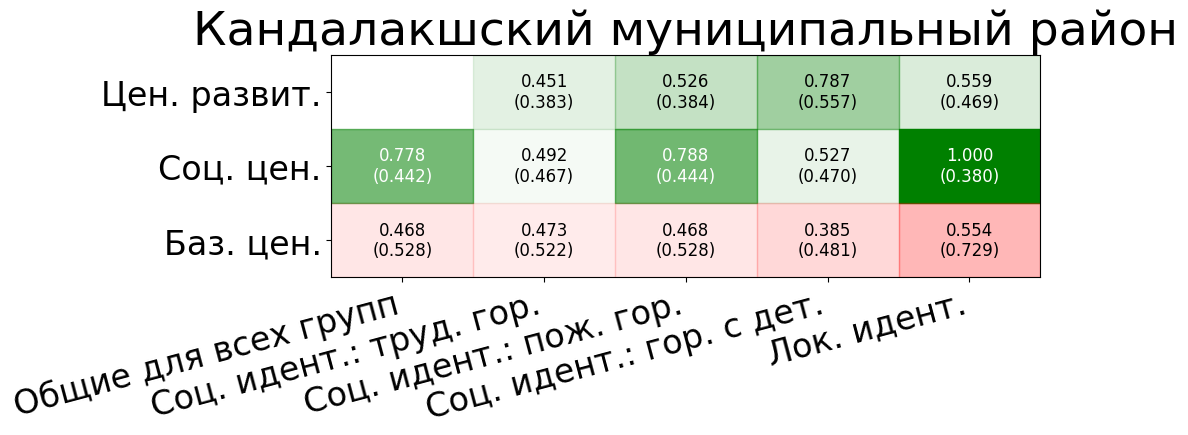

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Предполагается, что nlo_tab и sb_tab уже загружены в окружение

# 1. Собираем средние значения по Тюменской области
means = {}
for col in ['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc']:
    for row in ['dev', 'soc', 'base']:
        row_name = 'bas' if row == 'base' else row
        column_name = f'{col}_{row}'
        means[(row_name, col)] = nlo_tab[column_name].mean()

# 2. Словари для переименования строк и столбцов
column_names = {
    'comm': 'Общие для всех групп',
    'soc_workers': 'Соц. идент.: труд. гор.',
    'soc_old': 'Соц. идент.: пож. гор.',
    'soc_parents': 'Соц. идент.: гор. с дет.',
    'loc': 'Лок. идент.'
}
row_names = {
    'dev': 'Цен. развит.',
    'soc': 'Соц. цен.',
    'bas': 'Баз. цен.'
}

# 3. Переименовываем индексы и столбцы в sb_tab
sb_tab_renamed = sb_tab.copy()
sb_tab_renamed.index   = [row_names[i] for i in sb_tab.index]
sb_tab_renamed.columns = [column_names[c] for c in sb_tab.columns]

# 4. Первый проход: считаем max_diff
max_diff = 0.0
for disp_i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for disp_j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val      = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            max_diff = max(max_diff, abs(val - mean_val))

# 5. Функция подбора цвета
def get_color(val, mean_val, max_diff):
    diff      = val - mean_val
    intensity = min(abs(diff) / max_diff, 1.0)
    if diff >= 0:
        return mcolors.to_rgba('green', intensity)
    else:
        return mcolors.to_rgba('red', intensity)

# 6. Второй проход: собираем массивы и список "красных" ячеек
values      = np.zeros_like(sb_tab_renamed, dtype=float)
annotations = np.empty_like(sb_tab_renamed, dtype=object)
colors      = np.empty_like(sb_tab_renamed, dtype=object)
red_cells   = []  # тут будем хранить все diff < 0

for disp_i, orig_i in zip(sb_tab_renamed.index, sb_tab.index):
    for disp_j, orig_j in zip(sb_tab_renamed.columns, sb_tab.columns):
        ii = sb_tab_renamed.index.get_loc(disp_i)
        jj = sb_tab_renamed.columns.get_loc(disp_j)

        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            val      = sb_tab.loc[orig_i, orig_j]
            mean_val = means[(orig_i, orig_j)]
            diff     = val - mean_val

            # Если ячейка "красная" — сохраняем в список
            if diff < 0:
                red_cells.append({
                    'row':    disp_i,
                    'column': disp_j,
                    'value':  val,
                    'mean':   mean_val,
                    'diff':   diff
                })

            values[ii, jj]      = val
            annotations[ii, jj] = f'{val:.3f}\n({mean_val:.3f})'
            colors[ii, jj]      = get_color(val, mean_val, max_diff)
        else:
            values[ii, jj]      = np.nan
            annotations[ii, jj] = 'NaN'
            colors[ii, jj]      = mcolors.to_rgba('white', 1.0)

# 7. Выводим список всех "красных" ячеек
print("Ячейки, подсвеченные красным (val < mean):")
for cell in red_cells:
    print(f"{cell['row']} × {cell['column']}: "
          f"value={cell['value']:.3f}, mean={cell['mean']:.3f}, diff={cell['diff']:.3f}")

# (опционально) можно в виде DataFrame:
# red_df = pd.DataFrame(red_cells)
# display(red_df)

# 8. Рисуем тепловую карту
plt.figure(figsize=(11, 5))
for i in range(len(sb_tab_renamed.index)):
    for j in range(len(sb_tab_renamed.columns)):
        if not np.isnan(values[i, j]):
            plt.fill_between([j, j+1], [i, i], [i+1, i+1], color=colors[i, j])
            plt.text(
                j + 0.5, i + 0.5,
                annotations[i, j],
                ha='center', va='center', fontsize=12,
                color='black' if mcolors.to_rgba(colors[i, j])[3] < 0.5 else 'white'
            )

plt.ylim(len(sb_tab_renamed.index), 0)
plt.xlim(0, len(sb_tab_renamed.columns))
plt.xticks(np.arange(len(sb_tab_renamed.columns)) + 0.5,
           sb_tab_renamed.columns, rotation=15, ha='right')
plt.yticks(np.arange(len(sb_tab_renamed.index)) + 0.5,
           sb_tab_renamed.index)



plt.title('Кандалакшский муниципальный район')
plt.tight_layout()
plt.show()


result

In [ ]:
result.loc[(result['name'] == 'Кандалакшский муниципальный район')&(result.year ==2021), 'risk'] = 0.272

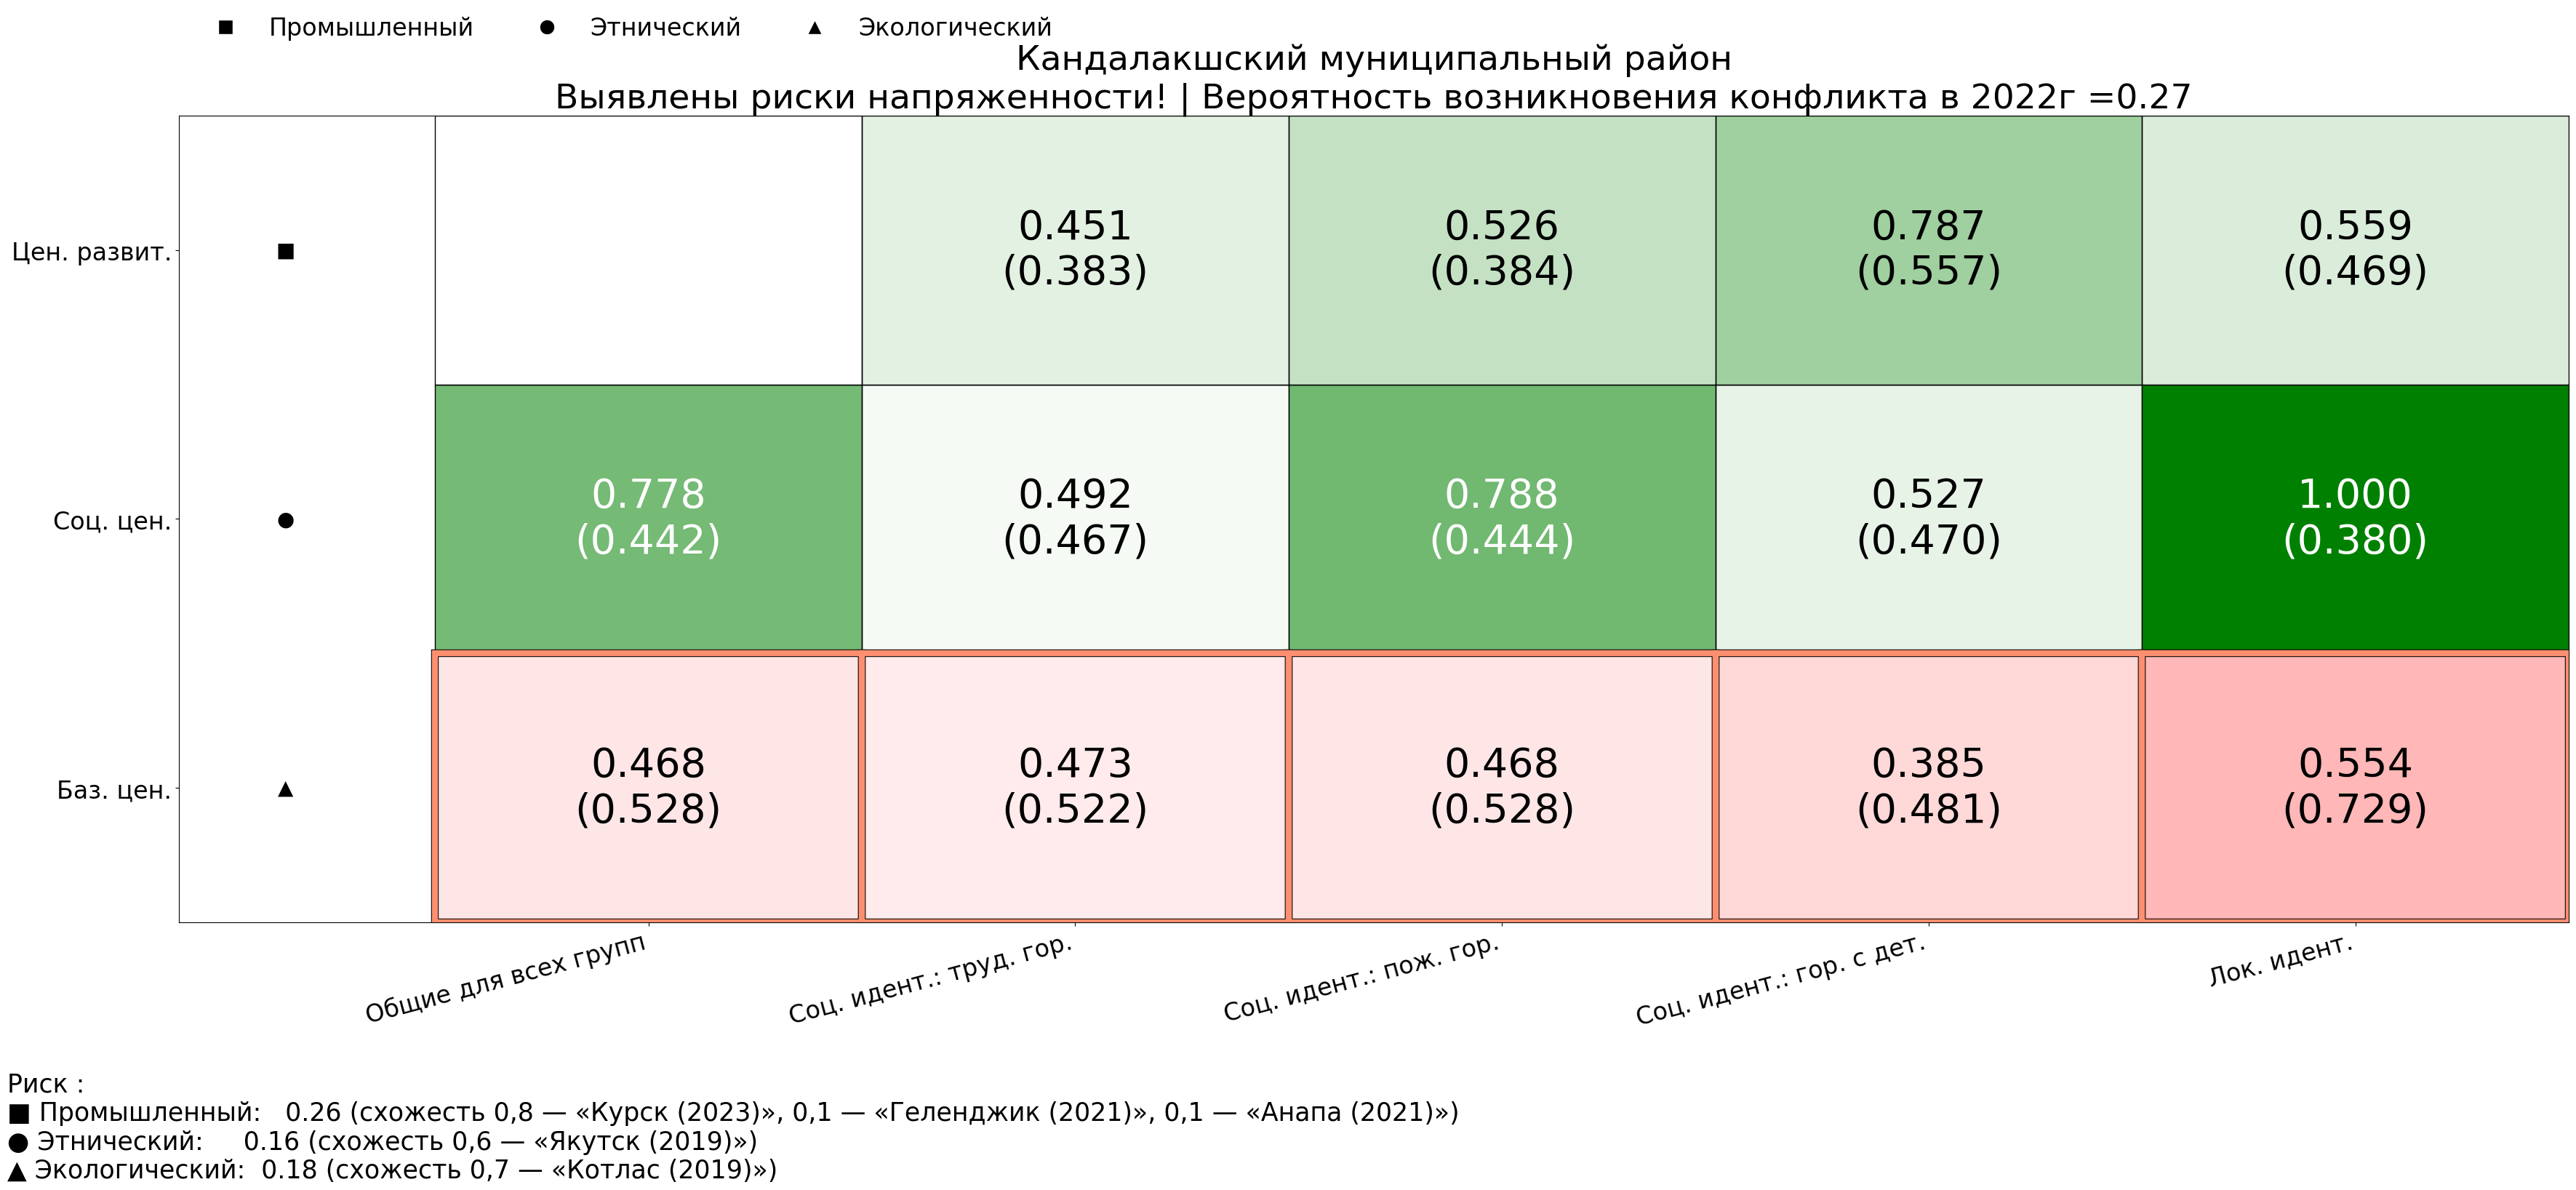

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------------
# 0) Кого рисуем
# ----------------------------
target_idx = sb.name if "sb" in globals() else 8807
target_oktmo = int(rez.loc[target_idx, "oktmo"])
target_year  = int(rez.loc[target_idx, "year"])
target_name  = str(rez.loc[target_idx, "name"]).strip()

group_risk_year = target_year + 1  # <-- СДВИГ ТОЛЬКО ДЛЯ ГРУППОВОГО РИСКА

# ----------------------------
# 1) Общий риск ДЛЯ ЗАГОЛОВКА (как было): берём из result['risk'] за target_year
# ----------------------------
risk_status = "no_data"   # no_data | zero | positive
total_prob = np.nan

rr = result[(result["oktmo"] == target_oktmo) & (result["year"] == target_year)]
if len(rr) > 0:
    v = pd.to_numeric(rr["risk"].iloc[0], errors="coerce")
    if not np.isnan(v):
        total_prob = float(v)
        risk_status = "zero" if total_prob == 0 else "positive"

# ----------------------------
# 2) Risk_for_illustration: берём за target_year+1
#    - схожесть по кейсам: колонки "1".."21"
#    - риски групп: "Экологический"/"Этнический"/"Промышленный"
# ----------------------------
CASE_NAME = {
    "1":  "Ленский район «Шиес» (2018)",
    "2":  "Полтавская (2022)",
    "3":  "Сысерт (2022)",
    "4":  "Павловск (2023)",
    "5":  "Лубянино (2020)",
    "6":  "Котлас (2019)",
    "7":  "Чемодановка (2019)",
    "8":  "Пугачевский (2013)",
    "9":  "Коркино (2024)",
    "10": "Удомля (2013)",
    "11": "Якутск (2019)",
    "12": "Махачкала (2023)",
    "13": "Ишимбайский район (2020)",
    "14": "Абзелиловский район (2020)",
    "15": "Курск (2023)",
    "16": "Новохоперск (2012)",
    "17": "Лаишевский район (2020)",
    "18": "Анапа (2021)",
    "19": "Геленджик (2021)",
    "20": "Ангарск (2020)",
    "21": "Турочак (2018)",
}

# группы кейсов (ничего не исключаем)
ECO_IDS = [str(i) for i in range(1, 7)]
ETH_IDS = [str(i) for i in range(7, 13)]
IND_IDS = [str(i) for i in range(13, 22)]

ill_df = pd.read_csv("/content/drive/MyDrive/НИР/НИР 3 сем /данные/Risk_for_illustration.csv")
ill_df.columns = [str(c).strip() for c in ill_df.columns]
ill_df["oktmo"] = pd.to_numeric(ill_df["oktmo"], errors="coerce").astype("Int64")
ill_df["year"]  = pd.to_numeric(ill_df["year"],  errors="coerce").astype("Int64")

ill_df.loc[(result['name'] == 'Кандалакшский муниципальный район')&(result.year ==2021), 'Экологический'] = 0.26
ill_df.loc[(result['name'] == 'Кандалакшский муниципальный район')&(result.year ==2021), 'Этнический'] = 0.16
ill_df.loc[(result['name'] == 'Кандалакшский муниципальный район')&(result.year ==2021), 'Промышленный'] = 0.18

eco_prob = eth_prob = ind_prob = 0.0
eco_series = eth_series = ind_series = None

rr_ill = ill_df[(ill_df["oktmo"] == target_oktmo) & (ill_df["year"] == group_risk_year)]
if len(rr_ill) > 0:
    ill_row = rr_ill.iloc[0]

    # значения групп риска — КАК ЕСТЬ
    eco_prob = float(pd.to_numeric(ill_row.get("Экологический", 0), errors="coerce") or 0)
    eth_prob = float(pd.to_numeric(ill_row.get("Этнический", 0), errors="coerce") or 0)
    ind_prob = float(pd.to_numeric(ill_row.get("Промышленный", 0), errors="coerce") or 0)

    # "схожесть" по кейсам 1..21
    def get_case_series(ids):
        data = {}
        for cid in ids:
            data[cid] = pd.to_numeric(ill_row.get(cid, 0), errors="coerce")
        return pd.Series(data).fillna(0)

    eco_series = get_case_series(ECO_IDS)
    eth_series = get_case_series(ETH_IDS)
    ind_series = get_case_series(IND_IDS)
else:
    # если нет строки — оставим нули и "не вычислена"
    pass

# ----------------------------
# 3) Схожесть (как раньше)
# ----------------------------
def fmt_ru(x, digits=1):
    return f"{x:.{digits}f}".replace(".", ",")

def cases_detail_text(series):
    if series is None:
        return "не вычислена"
    s = series[series > 0].sort_values(ascending=False)
    if len(s) == 0:
        return "не выявлена"
    parts = []
    for case_id, val in s.items():
        name = CASE_NAME.get(str(case_id), str(case_id))
        parts.append(f"{fmt_ru(float(val), 1)} — «{name}»")
    return ", ".join(parts)

eco_txt = cases_detail_text(eco_series)
eth_txt = cases_detail_text(eth_series)
ind_txt = cases_detail_text(ind_series)

# ----------------------------
# 4) Мэппинг строк -> группа риска (интенсивность = значения групп)
# ----------------------------
ROW_TO_GROUP = {
    "Цен. развит.": ("industrial", ind_prob),
    "Соц. цен.":    ("ethnic",     eth_prob),
    "Баз. цен.":    ("ecological", eco_prob),
}
GROUP_MARKER_TEXT = {"industrial": "■", "ethnic": "●", "ecological": "▲" }

# ----------------------------
# 5) Красные ячейки
# ----------------------------
red_set = set((c["row"], c["column"]) for c in red_cells)

# ----------------------------
# 6) Рисуем
# ----------------------------
n_rows = len(sb_tab_renamed.index)
n_cols = len(sb_tab_renamed.columns)
BASE = 14

plt.rcParams.update({
    "font.size": BASE+ 14,
    "axes.titlesize": BASE + 20,
    "axes.labelsize": BASE+ 10,
    "xtick.labelsize": BASE+ 10,
    "ytick.labelsize": BASE+ 10,
    "legend.fontsize": BASE+ 10,
})

fig, ax = plt.subplots(figsize=(18, 8))

# матрица: рисуем NaN как белые клетки
for i in range(n_rows):
    for j in range(n_cols):
        is_nan = np.isnan(values[i, j])
        face = (1, 1, 1, 1) if is_nan else colors[i, j]

        ax.add_patch(Rectangle((j, i), 1, 1, facecolor=face, edgecolor="black", zorder=1))

        if not is_nan:
            ax.text(j + 0.5, i + 0.5, annotations[i, j],
                    ha="center", va="center", fontsize=40,
                    color="black" if mcolors.to_rgba(face)[3] < 0.5 else "white",
                    zorder=2)

# обводки: если общий риск positive и есть красные ячейки
# интенсивность берём "как есть", но для цвета ограничим 0..1
# обводки: если общий риск positive и есть красные ячейки
if risk_status == "positive" and len(red_set) > 0:
    BAND_LW = 6
    BLACK_LW = 1.2  # тонкая черная обводка
    BLACK_LW = BAND_LW + 1.5
    COLOR_LW = BAND_LW
    for i, rname in enumerate(sb_tab_renamed.index):
        g, intensity = ROW_TO_GROUP.get(rname, (None, 0.0))
        if g is None:
            continue

        intensity_for_color = float(np.clip(intensity, 0, 1))
        if intensity_for_color <= 0:
            continue

        col = plt.cm.Reds(0.25 + 0.75 * intensity_for_color)

        for j, cname in enumerate(sb_tab_renamed.columns):
            if (rname, cname) not in red_set:
                continue
            if np.isnan(values[i, j]):
                continue

            # 1) тонкая черная рамка (под цветной)
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False,
                                   edgecolor="black", linewidth=BLACK_LW,
                                   zorder=9))

            # 2) толстая цветная рамка (поверх)
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False,
                                   edgecolor=col, linewidth=BAND_LW,
                                   zorder=10))
# оси/подписи
ax.set_ylim(n_rows, 0)
ax.set_xlim(-0.6, n_cols)
ax.set_xticks(np.arange(n_cols) + 0.5)
ax.set_xticklabels(sb_tab_renamed.columns, rotation=15, ha="right")
ax.set_yticks(np.arange(n_rows) + 0.5)
ax.set_yticklabels(sb_tab_renamed.index)

# значки возле строк
for i, rname in enumerate(sb_tab_renamed.index):
    g, _ = ROW_TO_GROUP.get(rname, (None, 0.0))
    if g is None:
        continue
    ax.text(-0.35, i + 0.5, GROUP_MARKER_TEXT[g], fontsize=20,
            va="center", ha="center", zorder=20)

# заголовок (общий риск БЕЗ сдвига)
if risk_status == "no_data":
    title2 = "Нет данных по риску"
    extra = ""
elif risk_status == "zero":
    title2 = "Риск конфликта статистически не выявлен"
    extra = f"Вероятность возникновения конфликта в 2022г ={total_prob:.2f}" if not np.isnan(total_prob) else ""
else:
    title2 = "Выявлены риски напряженности!"
    extra = f"| Вероятность возникновения конфликта в 2022г ={total_prob:.2f}"

ax.set_title(f"{target_name}\n{title2} {extra}")

# легенда
legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="black", markersize=15, label="Промышленный"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=15, label="Этнический"),
    Line2D([0], [0], marker="^", color="w", markerfacecolor="black", markersize=15, label="Экологический"),
]
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(0, 1.15),
          ncol=3, frameon=False)

# footer: риски групп (за target_year+1) + схожесть
footer = (
    f"Риск :\n"
    f"■ Промышленный:   {ind_prob:.2f} (схожесть {ind_txt})\n"
    f"● Этнический:     {eth_prob:.2f} (схожесть {eth_txt})\n"
    f"▲ Экологический:  {eco_prob:.2f} (схожесть {eco_txt})"

)
fig.text(0.02, -0.02, footer, ha="left", va="top", fontsize=25)

plt.tight_layout(rect=[0, 0, 2, 1.8])
plt.show()

## метод оптимизации


In [ ]:
import numpy as np
import pandas as pd

# Средние по области
means = {}
for col in ['comm', 'soc_workers', 'soc_old', 'soc_parents', 'loc']:
    for row in ['dev', 'soc', 'base']:
        rk = 'bas' if row == 'base' else row
        means[(rk, col)] = nlo_tab[f'{col}_{row}'].mean()

# Переименования для отображения sb_tab
col_names = {
    'comm': 'Общие', 'soc_workers': 'Соц. труд.',
    'soc_old': 'Соц. пож.', 'soc_parents': 'Соц. семьи',
    'loc': 'Лок.'
}
row_names = {'dev': 'Цен.развит.', 'soc': 'Соц.цен.', 'bas': 'Баз.цен.'}

sb_disp = sb_tab.copy()
sb_disp.index   = [row_names[i] for i in sb_tab.index]
sb_disp.columns = [col_names[c] for c in sb_tab.columns]

# Находим «красные» ячейки (v < mean)
red_cells = []
for disp_i, orig_i in zip(sb_disp.index, sb_tab.index):
    for disp_j, orig_j in zip(sb_disp.columns, sb_tab.columns):
        if pd.notna(sb_tab.loc[orig_i, orig_j]):
            v = sb_tab.loc[orig_i, orig_j]
            m = means[(orig_i, orig_j)]
            if v < m:
                red_cells.append({'col_key': orig_j, 'row_key': orig_i})

#  Формируем active_groups (преобразуем bas→base)
active_groups = sorted({
    f"{cell['col_key']}_{'base' if cell['row_key']=='bas' else cell['row_key']}"
    for cell in red_cells
})

# Полный словарь групп факторов (ключи _base)
all_groups = {
    'comm_dev': [], 'soc_workers_dev': ["avgsaldiff"],
    'soc_old_dev': ['library'],
    'soc_parents_dev': ['musartschool','sportschool','beforeschool','schoolnum'],
    'loc_dev': ['naturesecure'],
    'comm_soc': ['hospitals','docsnum', 'roadslen'],
    'soc_workers_soc': ['hospitals','docsnum', 'livestock', 'agrprod', 'roadslen',
                        'avgsalary','foodservturnover','cinemas'],
    'soc_old_soc': ['hospitals','docsnum', 'roadslen'],
    'soc_parents_soc': ['hospitals','docsnum',
                        'avgsalary','foodservturnover','zoos','circuses','cinemas'],
    'loc_soc': ['cultureorg','theatres'],
    'comm_base': ['servicesnum','munipoliceworkers'],
    'soc_workers_base': ['servicesnum','pollutionvol','munipoliceworkers','badcompanies'],
    'soc_old_base': ['servicesnum','pollutionvol','munipoliceworkers'],
    'soc_parents_base': ['servicesnum','pollutionvol','munipoliceworkers','badcompanies'],
    'loc_base': ['badhousesdwellers']
}

#Отбираем факторы по активным группам
feature_groups = {grp: all_groups[grp] for grp in active_groups}
features = list({f for sub in feature_groups.values() for f in sub})

# Фильтрация кластера (ОКТМО 71xxxxxx + ydel_saldo>0)
result['oktmo'] = pd.to_numeric(result['oktmo'], errors='coerce')
cluster = result[
    (result['oktmo'] >= 47000000) &
    (result['oktmo'] <  48000000) &
    (result['ydel_saldo'] >   0)
]

#  Поиск строки
mask_name = result['name'].str.contains('Кандалакшский муниципальный район', na=False)
if 'year' in result.columns:
    mask = mask_name & (result['year'] == 2021)
else:
    mask = mask_name

if not mask.any():
    raise ValueError("Не найдена запись Кандалакшский муниципальный район за 2022 год")
nadym_idx = result.index[mask][0]
# Средние по выбранным факторам в регионе
region_means = cluster[features].mean()

#  Логика корректировки
#  Логика корректировки
k = 0.30  # <-- если не нужно 10% от среднего, поставь 0.0
special = ['badcompanies', 'badhousesdwellers', 'pollutionvol', 'funds']

orig = result.loc[nadym_idx, features].astype(float).copy()

# население (для 1/popsize)
pop = pd.to_numeric(result.at[nadym_idx, 'popsize'], errors='coerce')

# сюда считаем новые значения (потом запишем в result)
new_vals = orig.copy()

# сюда пишем "особые" значения ТОЛЬКО для NaN-случаев, иначе NaN
special_new_value = pd.Series(np.nan, index=features, dtype=float)

# Средние по выбранным факторам в регионе
region_means = cluster[features].apply(pd.to_numeric, errors='coerce').mean()

for f in features:
    curr = orig[f]
    mean = region_means.get(f, np.nan)

    # --- СЛУЧАЙ NaN В ИСХОДНЫХ ДАННЫХ ---
    if pd.isna(curr):
        # old_value считаем 0 (для отчёта), new_value задаём по правилам:
        if f in special:
            new_vals[f] = 0.0
        else:
            if pd.notna(pop) and pop > 0:
                new_vals[f] = 3.0 / float(pop)
            else:
                new_vals[f] = np.nan  # если popsize нет, не можем посчитать

        # записываем в отдельный столбец для CSV (только эти случаи!)
        special_new_value[f] = new_vals[f]
        continue

    # --- ДАЛЬШЕ: обычная корректировка для НЕ-NaN ---
    # пропускаем нули, NaN среднего, и уже равные среднему
    if curr == 0 or pd.isna(mean) or curr == mean:
        continue

    if f in special:
        # "плохие": уменьшаем только если выше среднего
        if curr > mean:
            new_vals[f] = mean * (1 - k)  # 0.9*mean если k=0.10, иначе просто mean
    else:
        # "хорошие": увеличиваем только если ниже среднего
        if curr < mean:
            new_vals[f] = mean * (1 + k)  # 1.1*mean если k=0.10, иначе просто mean

# --- ВАЖНО: записываем новые значения обратно в result ---
result.loc[nadym_idx, features] = new_vals.values

# --- Итоговая таблица сравнения ---
old_for_report = orig.copy()
old_for_report[pd.isna(old_for_report)] = 0.0

comparison = pd.DataFrame({
    'old_value':        old_for_report,
    'region_mean':      region_means,
    'new_value':        new_vals,
    'special_new_value': special_new_value  # <-- новый столбец
})

comparison['abs_change'] = comparison['new_value'] - comparison['old_value']

comparison['pct_change'] = np.where(
    comparison['old_value'] != 0,
    comparison['abs_change'] / comparison['old_value'] * 100,
    np.nan
)

print("Сравнение значений Кандалакшский муниципальный район 2022 (до/после) с региональным средним:")
print(comparison.to_string(formatters={
    'old_value': '{:.5f}'.format,
    'region_mean': '{:.5f}'.format,
    'new_value': '{:.5f}'.format,
    'special_new_value': '{:.5f}'.format,
    'abs_change': '{:.5f}'.format,
    'pct_change': '{:.5f}'.format
}))

out_df = (comparison.reset_index()
          .rename(columns={'index': 'feature'})[['feature', 'pct_change', 'special_new_value']])
out_df.to_csv('Кандалакшский муниципальный район.csv', index=False)


Сравнение значений Кандалакшский муниципальный район 2022 (до/после) с региональным средним:
                    old_value region_mean   new_value special_new_value  abs_change  pct_change
zoos                  0.00000     0.00003     0.00007           0.00007     0.00007         NaN
badhousesdwellers     0.06125     0.02167     0.01517               NaN    -0.04609   -75.24037
avgsalary         61024.00000 62208.18750 80870.64375               NaN 19846.64375    32.52269
cinemas               0.00002     0.00003     0.00004               NaN     0.00002    79.61940
pollutionvol          0.00064     0.00438     0.00064               NaN     0.00000     0.00000
cultureorg            0.00009     0.00012     0.00015               NaN     0.00006    68.40332
servicesnum           0.00346     0.00357     0.00464               NaN     0.00117    33.89930
agrprod               3.59955     4.72942     6.14824               NaN     2.54869    70.80569
munipoliceworkers     0.00000         NaN  